<a href="https://colab.research.google.com/github/mfwz247/Arabic-CNN-Based-OCR/blob/main/Approach%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import the necessary packages
import imutils
def sliding_window(image, step, ws):
	# slide a window across the image
	for y in range(0, image.shape[0] - ws[1], step):
		for x in range(0, image.shape[1] - ws[0], step):
			# yield the current window
			yield (x, y, image[y:y + ws[1], x:x + ws[0]])

In [2]:
def image_pyramid(image, scale=1, minSize=(10, 10)):
	# yield the original image
	yield image
	# keep looping over the image pyramid
	while True:
		# compute the dimensions of the next image in the pyramid
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)
		# if the resized image does not meet the supplied minimum
		# size, then stop constructing the pyramid
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break
		# yield the next image in the pyramid
		yield image

In [3]:
# import the necessary packages
from PIL import ImageFont, ImageDraw, Image
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array 
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import time
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# initialize variables used for the object detection procedure
WIDTH = 500
PYR_SCALE = 3
WIN_STEP = 8
ROI_SIZE = eval("(100,180)")
INPUT_SIZE = (22, 22)

In [5]:
# load our network weights from disk
print("[INFO] loading network...")
model = load_model("/content/Model/MF")
# load the input image from disk, resize it such that it has the
# has the supplied width, and then grab its dimensions
orig = cv2.imread("/content/saeed.png")
orig = imutils.resize(orig, width=WIDTH)
(H, W) = orig.shape[:2]

[INFO] loading network...


In [6]:
 
 #initialize the image pyramid
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)
# initialize two lists, one to hold the ROIs generated from the image
# pyramid and sliding window, and another list used to store the
# (x, y)-coordinates of where the ROI was in the original image
rois = []
locs = []
# time how long it takes to loop over the image pyramid layers and
# sliding window locations
start = time.time()

In [7]:
for image in pyramid:
  scale = W / float(image.shape[1])
  for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
    x = int(x * scale)
    y = int(y * scale)
    w = int(ROI_SIZE[0] * scale)
    h = int(ROI_SIZE[1] * scale)
    gray= cv2.cvtColor(roiOrig,cv2.COLOR_BGR2GRAY)
    ret,inv = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV)
    roi = cv2.resize(inv, INPUT_SIZE)
    roi = img_to_array(roi)
    cv2.imwrite("preprocess.jpeg",roi)
    rois.append(roi)
    locs.append((x, y, x + w, y + h))

In [8]:
clone = orig.copy()
cv2.rectangle(clone, (x, y), (x + w, y + h),(0, 255, 0), 2)
cv2.imwrite("Visualization.jpeg", clone)
cv2.imwrite("ROI.jpeg", roiOrig)

True

In [9]:
# show how long it took to loop over the image pyramid layers and
# sliding window locations
end = time.time()
print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(
	end - start))
# convert the ROIs to a NumPy array
rois = np.array(rois, dtype="float32")
# classify each of the proposal ROIs using ResNet and then show how
# long the classifications took
print("[INFO] classifying ROIs...")
start = time.time()
preds = model.predict(rois)
end = time.time()
print("[INFO] classifying ROIs took {:.5f} seconds".format(end - start))
# decode the predictions and initialize a dictionary which maps class
# labels (keys) to any ROIs associated with that label (values)
classes=['ا','ب','ت','ث','ج','ح','خ','د','ذ','ر','ز','س','ش','ص','ض','ط','ظ','ع','غ','ف','ق','ك','ل','لا','م','ن','ه','و','ي']

# Find index of maximum value from 2D numpy array

result = np.where(preds == np.amax(preds))
maxInColumns = np.amax(preds, axis=1)
# zip the 2 arrays to get the exact coordinates

cls=[]

for i in range(len(result[1])):

  ix=result[1][i]
  cls.append(classes[ix])

listOfCordinates = list(zip(maxInColumns,cls))

def extractDigits(lst):
    return list(map(lambda el:[el], lst))

preds=extractDigits(listOfCordinates)
# travese over the list of cordinates
   
preds =np.array(preds)

labels = {}

[INFO] looping over pyramid/windows took 0.25286 seconds
[INFO] classifying ROIs...
[INFO] classifying ROIs took 0.48740 seconds


In [10]:
for (i, p) in enumerate(preds):

  prob=float(p[0][0])
  label=p[0][1]
  label=str(label)
 

  if prob >= 0.0005:
    box = locs[i]
    L = labels.get(label, [])
    L.append((box, prob))
    labels[label] = L
    

In [11]:
# loop over the labels for each of detected objects in the image
for label in labels.keys():
	# clone the original image so that we can draw on it
	print("[INFO] showing results for '{}'".format(label))
	clone = orig.copy()
	# loop over all bounding boxes for the current label
	for (box, prob) in labels[label]:
		# draw the bounding box on the image
		(startX, startY, endX, endY) = box
		cv2.rectangle(clone, (startX, startY), (endX, endY),
			(0, 255, 0), 2)
	# show the results *before* applying non-maxima suppression, then
	# clone the image again so we can display the results *after*
	# applying non-maxima suppression
	cv2.imwrite("Before.jpeg", clone)
	clone = orig.copy()

[INFO] showing results for 'ي'
[INFO] showing results for 'ض'
[INFO] showing results for 'س'
[INFO] showing results for 'ت'
[INFO] showing results for 'لا'


لا


-1

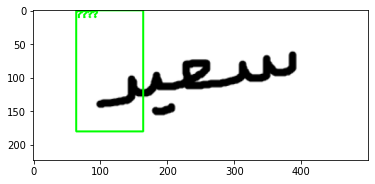

In [12]:
boxes = np.array([p[0] for p in labels[label]])
proba = np.array([p[1] for p in labels[label]])
boxes = non_max_suppression(boxes, proba)
for (startX, startY, endX, endY) in boxes:
	
	print(format(label))
	cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
	y = startY - 10 if startY - 10 > 10 else startY + 10
	cv2.putText(clone, str(format(label)), (startX, y),
	            cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
cv2.imwrite("After.jpeg", clone)
plt.imshow(clone)
cv2.waitKey(0)

In [13]:
# from keras.applications.imagenet_utils import preprocess_input



# model = load_model("/content/Model/MFA2.h5")

# # resize image
# img = keras.utils.load_img("/content/67-3.jpg", target_size=(64, 64), color_mode="grayscale")

# img_array = keras.utils.img_to_array(img)

# img_batch = np.expand_dims(img_array, axis=0)

# # img_preprocessed = preprocess_input(img_batch)


# preds=np.argmax(model.predict(img_batch))
# print(preds)


In [14]:
# !kaggle kernels output muhammadfawzy/letter-forms-recognizer -p "/content/Model"

In [15]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))
  
# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json